In [11]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow.keras import layers
import random
from collections import deque

import gym
from gym import spaces

In [12]:
# number of periods for charging episode
# from 2 - 4 pm with charging lasting 15 min
#length in minutes
charging_periods_length = 15
number_periods = 8

#set a seed ofr normal distributed demand
np.random.seed(1)

#Definitions of actions
# Discrete action methods zero, low, medium, high.high max 22 kwh prorrate between de different 
zero_action = 0
low_action = 7
medium_action = 16
high_action = 22
possible_actions = [zero_action, low_action, medium_action, high_action]

#Definition of demand or capacity of the battery to be charged is normal distributed
def battery_demand():
    # battery demand in kwh
    battery_demand_mean = 30
    battery_demand_std = 5
    demand = np.random.normal(battery_demand_mean, battery_demand_std, 1)[0]
    return demand

#definition of the time being charged in each period
#minimum of the charge possible in the time , and time to charge what is left for full capacity
def time_charging (initial_charge, goal_charge, charging_rate):
    charging_periods_length = 15
    remaining_charge = goal_charge - initial_charge
    if charging_rate == 0:
        time_hour = 0
    else:
        time_hour = remaining_charge / charging_rate
    time_minute = min(time_hour * 60, charging_periods_length)
    #return time in minutes
    return time_minute

#functions that indicates the amount of enegy charged in the time period
def recharge_production( time, charging_rate ):
    time_hour = time / 60
    energy_prod = time_hour * charging_rate
    #return energy charged in kwh
    return energy_prod

# consider a very high penalty for running out of energy or not fulfilling the demand
# I define the penaltu as the the cost of charging at full power for all the periods
not_reach_demand_cost = number_periods * charging_periods_length / 60 * math.exp(high_action)

#define the recharge cost as the function indicated in the instructions
#charging cost (t,p)=Σ𝛼𝑡𝑒𝑝𝑡∈𝑇), where 𝛼𝑡 is the time coefficient and p is the charging rate.

def recharge_cost(time, charging_rate):
    #price per kwh
    power = charging_rate
    alfa = time / 60
    cost = alfa * math.exp(power)
    return cost

#test policy action function
def policy_action(choices):
    action = random.choice(choices)
    return action

# value function is the cost of charging + the penalization in case that the battery is not fully charged in the last period
def value_function(time, rate, index, initial_charge, period_charge, goal_charge):
    if index == 8 and initial_charge + period_charge < goal_charge:
        cost = recharge_cost(time, rate) + not_reach_demand_cost
    else:
        cost = recharge_cost(time, rate)
    return cost


In [13]:
#we use a Q-learning algorithm of deep learning to predict the best action to each state
#Q-learning algorithm, which is a popular model-free RL algorithm.
# we buil the environment with the gym library for defining the environment
# https://www.gymlibrary.dev/content/environment_creation/

#We'll create a custom environment that inherits from gym.Env.
class BatteryChargingEnv(gym.Env):
    def __init__(self):
        super(BatteryChargingEnv, self).__init__()
        # define four possible actions: 0, 7, 14, 22
        self.action_space = spaces.Discrete(4)
        # define the observation space with total_capacity, current_charge and current period
        self.observation_space = spaces.Box(low=np.array([0, 0, 0]), high=np.array([100, 100, 8]), dtype=np.float32)  # Continuous state space
        self.total_capacity = battery_demand()
        self.charge_rates = possible_actions
        self.time_penalty = not_reach_demand_cost
    
    #we define a function to reset the environment state after an epsido
    def reset(self):
        #define intial values
        self.total_capacity = battery_demand()
        self.current_charge = 0
        self.current_period = 0
        #assign the state and return the state
        self.state = np.array([self.total_capacity, self.current_charge, self.current_period])
        return self.state
    
     # show progress
    def render(self, mode='human', close=False):
        print(f"Period: {self.current_period}, Current Charge: {self.current_charge}/{self.total_capacity}")

    def step(self, action):
        # chosen action
        charge_rate = self.charge_rates[action]
        # define the time charging
        time = time_charging(self.current_charge, self.total_capacity, charge_rate)
        # production energy charged
        production = recharge_production(time, charge_rate)
        # update state variables
        self.current_charge += production
        self.current_period += 1
        done = self.current_period == 8
        # reward
        cost = value_function(time, charge_rate, self.current_period, self.current_charge, production, self.total_capacity)
        reward = -cost
        self.state = np.array([self.total_capacity, self.current_charge, self.current_period])
        self.render()
        #return the historical state and reward
        return self.state, reward, done, {}
    
# create environment instance        
env = BatteryChargingEnv()


In [14]:
# define q model agent that will learn how to take policies
# since we have a continuos state we need a deep Q network to optimize
# keras sequential multilayer model

def create_q_model(num_states, num_actions):
    model = tf.keras.Sequential()
    model.add(layers.Dense(12, activation='relu', input_shape=(num_states,)))
    model.add(layers.Dense(12, activation='relu'))
    model.add(layers.Dense(num_actions, activation='linear'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
    return model

num_states = env.observation_space.shape[0]
num_actions = env.action_space.n

#why 2 models
q_model = create_q_model(num_states, num_actions)
target_q_model = create_q_model(num_states, num_actions)


In [15]:
#define dqn agent
import random
from collections import deque

class DQNAgent:
    def __init__(self, env, gamma=0.99, batch_size=8, max_exploration_rate=0.3, min_exploration_rate=0.01, exploration_decay=0.995):
        #initiate with the environment
        self.env = env
        #discount rate, necessary?
        self.gamma = gamma
        # number of experiences used in each training iteration (state, action, reward)
        self.batch_size = batch_size
        # initial rate at which the agent explores the environment by taking random actions
        self.exploration_rate = max_exploration_rate
        self.max_exploration_rate = max_exploration_rate
        # This parameter sets a lower bound on the exploration rate to ensure that the agent always has some probability of exploring new action
        self.min_exploration_rate = min_exploration_rate
        # how quickly the exploration rate decreases from max_exploration_rate to min_exploration_rate over time.
        self.exploration_decay = exploration_decay
        #store experiences that the agent collects while interacting with the environment.
        self.memory = deque(maxlen=2000)
        # create the agents models
        self.q_model = create_q_model(env.observation_space.shape[0], env.action_space.n)
        self.target_q_model = create_q_model(env.observation_space.shape[0], env.action_space.n)
        self.update_target_network()
    
    # update de target model weights with the q model weights
    # the target Q-network is used to compute the target Q-values. By updating the target network less frequently,
    #we reduce the likelihood of oscillations and divergence during training.
    def update_target_network(self):
        self.target_q_model.set_weights(self.q_model.get_weights())

    # adds a new experience tuple to the memory
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    #defines if the action taken si exploratory random or uses the prediction of the model 
    def choose_action(self, state):
        if np.random.rand() < self.exploration_rate:
            #sample a random action
            return self.env.action_space.sample()
        # Predicting Q-values for Exploitation
        # Uses the main Q-network to predict the Q-values for all possible actions given the current state
        q_values = self.q_model.predict(state[np.newaxis])
        # Selects the action with the highest Q-value
        # we only need the first (and only) prediction in this batch.
        return np.argmax(q_values[0])

    #samples a random mini-batch of experiences from the memory to update the Q-network.
    def replay(self):
        #return only if the memory has at least the number of experience of the batch
        if len(self.memory) < self.batch_size:
            return
        # we take a random sample of the memory as a batch to train
        minibatch = random.sample(self.memory, self.batch_size)
        # for every instance of the batch
        for state, action, reward, next_state, done in minibatch:
            #we make a prediction of the reward of every action accroding to the state
            target = self.q_model.predict(state[np.newaxis])
            if done:
                #if it is the last iteration we update the reward as the the reward from the environment
                target[0][action] = reward
            else:
                # it is not the last iteration with the reward +  estimation of future rewards (future rewards as a prediction of next state)
                t = self.target_q_model.predict(next_state[np.newaxis])
                target[0][action] = reward + self.gamma * np.amax(t)
            #we fit the model to update the weights of the neural network
            self.q_model.fit(state[np.newaxis], target, epochs=1, verbose=0)
        #we decrease the exploration rate of the model to promote convergence
        self.exploration_rate = max(self.min_exploration_rate, self.exploration_rate * self.exploration_decay)

agent = DQNAgent(env)
        


In [17]:
# training of the model

# we define the number of episodes
num_episodes = 200
reward_train_history = []

for episode in range(num_episodes):
    #reset environment to intial values
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        #generate and action according to the current state
        action = agent.choose_action(state)
        #we obtain the next state and reward according to the environment
        next_state, reward, done, _ = env.step(action)
        # we save the instance in the agent
        agent.remember(state, action, reward, next_state, done)
        # we run the iteration to train the model only when the number of instances surpass the iterations surpass the batch size
        agent.replay()
        # update the next state
        state = next_state
        #save the total reward
        total_reward += reward
    # history appending
    reward_train_history.append(total_reward)
    #we update the target network
    agent.update_target_network()
    
    if episode % 8 == 0:
        print(f"Episode {episode}, Total Reward: {total_reward}, Exploration Rate: {agent.exploration_rate}")

print("Training finished.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Period: 1, Current Charge: 1.75/30.99149860063385
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Period: 2, Current Charge: 1.75/30.99149860063385
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

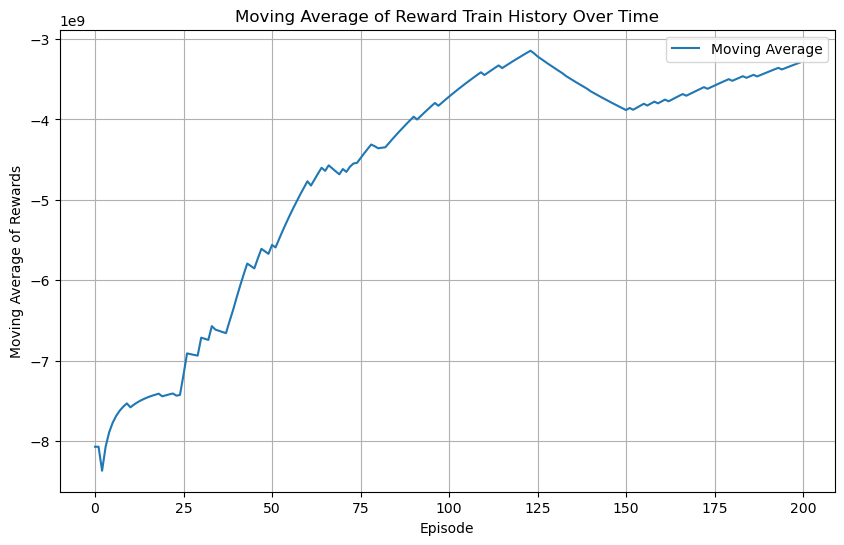

In [18]:
moving_average = [np.mean(reward_train_history[:i+1]) for i in range(len(reward_train_history))]

# Plotting the moving average
plt.figure(figsize=(10, 6))
plt.plot(moving_average, label="Moving Average")
plt.xlabel('Episode')
plt.ylabel('Moving Average of Rewards')
plt.title('Moving Average of Reward Train History Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
#cumulative cost
total_cost = 0
#define the numer of episodes where to test
num_episodes = 100

#for every episode
for episode in range(num_episodes):
    #reset the state of the environment
    state = env.reset()
    done = False

    while not done:
        #predict an action with the agent given the state
        action = np.random.choice(range(4))
        # run the simulation to the next step
        next_state, reward, done, _ = env.step(action)
        total_cost -= reward  # Since reward is negative cost
        state = next_state

average_cost = total_cost / num_episodes
print(f"Average cost over {num_episodes} episodes: {average_cost}")

Period: 1, Current Charge: 4.0/30.042943052258085
Period: 2, Current Charge: 4.0/30.042943052258085
Period: 3, Current Charge: 8.0/30.042943052258085
Period: 4, Current Charge: 9.75/30.042943052258085
Period: 5, Current Charge: 9.75/30.042943052258085
Period: 6, Current Charge: 11.5/30.042943052258085
Period: 7, Current Charge: 13.25/30.042943052258085
Period: 8, Current Charge: 17.25/30.042943052258085
Period: 1, Current Charge: 5.5/24.706765085300177
Period: 2, Current Charge: 11.0/24.706765085300177
Period: 3, Current Charge: 11.0/24.706765085300177
Period: 4, Current Charge: 15.0/24.706765085300177
Period: 5, Current Charge: 15.0/24.706765085300177
Period: 6, Current Charge: 16.75/24.706765085300177
Period: 7, Current Charge: 16.75/24.706765085300177
Period: 8, Current Charge: 22.25/24.706765085300177
Period: 1, Current Charge: 4.0/34.695863359451636
Period: 2, Current Charge: 5.75/34.695863359451636
Period: 3, Current Charge: 5.75/34.695863359451636
Period: 4, Current Charge: 11.2

In [22]:
#cumulative cost
total_cost = 0
num_episodes = 100

for episode in range(num_episodes):
    state = env.reset()
    done = False

    while not done:
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        total_cost -= reward  # Since reward is negative cost
        state = next_state

average_cost = total_cost / num_episodes
print(f"Average cost over {num_episodes} episodes: {average_cost}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Period: 1, Current Charge: 4.0/26.48689861284424
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Period: 2, Current Charge: 8.0/26.48689861284424
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Period: 3, Current Charge: 12.0/26.48689861284424
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Period: 4, Current Charge: 16.0/26.48689861284424
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Period: 5, Current Charge: 20.0/26.48689861284424
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Period: 6, Current Charge: 24.0/26.48689861284424
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Period: 7, Current Charge: 26.48689861284424/26.48689861284424
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Period: 8, Current Charge: 26.48689861284424/26.48689861284424
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Period: 1, Current Charge: 4.0/21.441175674697735
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Period: 2, Current Charge: 8.0/21.441175674697735
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Period: 3, Current Charge: 12.0/21.441175674697735
1/1 ━━━━━